In [1]:
import gymnasium as gym
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


# Criando o ambiente FrozenLake-v0 com is_slippery=False
env = gym.make('FrozenLake-v1', is_slippery=False)

https://gymnasium.farama.org/environments/toy_text/frozen_lake/

## Passo 1: rodar política base para obter D(s,a,s')

In [2]:

def generate_dataset(env, num_episodes):
    """
    Gera um conjunto de dados estruturado em episódios.

    Args:
        env: O ambiente OpenAI Gym.
        num_episodes: Número de episódios a serem gerados.

    Returns:
        episodes: Lista de episódios, onde cada episódio é uma lista de transições.
    """
    episodes = []

    for _ in range(num_episodes):
        state = env.reset()
        episode = []
        done = False
        truncated = False

        while not (done or truncated):
            action = env.action_space.sample()  # Ação aleatória
            next_state, reward, done, truncated, _ = env.step(action)

            if type(state) == tuple:  # Tratando estados que podem ser tuplas
                state = state[0]

            # Adicionar a transição ao episódio
            episode.append((state, int(action), reward, next_state))
            state = next_state

        # Adicionar o episódio à lista de episódios
        episodes.append(episode)

    return episodes

num_episodes = 100
episodes = generate_dataset(env, num_episodes)

# Exibindo informações sobre o conjunto de dados
print(f"Total de episódios gerados: {len(episodes)}")
print(f"Exemplo de transição no primeiro episódio: {episodes[0][1]}")  # Primeira transição do primeiro episódio
print(f"Tamanho do primeiro episódio: {len(episodes[0])}")
print(f"Exemplo de episódio: {episodes[0]}")

# Fechando o ambiente
env.close()

Total de episódios gerados: 100
Exemplo de transição no primeiro episódio: (0, 3, 0.0, 0)
Tamanho do primeiro episódio: 14
Exemplo de episódio: [(0, 0, 0.0, 0), (0, 3, 0.0, 0), (0, 3, 0.0, 0), (0, 0, 0.0, 0), (0, 0, 0.0, 0), (0, 0, 0.0, 0), (0, 0, 0.0, 0), (0, 2, 0.0, 1), (1, 0, 0.0, 0), (0, 0, 0.0, 0), (0, 1, 0.0, 4), (4, 1, 0.0, 8), (8, 0, 0.0, 8), (8, 1, 0.0, 12)]


## Passo 2: aprender o modelo de RL para podemos prever as dinâmicas

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

def prepare_dataset(episodes):
    """
    Prepara os dados para o modelo de transição.

    Args:
        episodes: Lista de episódios, onde cada episódio é uma lista de transições.

    Returns:
        X: Array de features (state, action).
        y: Array de alvos (next_state).
    """
    X = []
    y = []

    for episode in episodes:
        for transition in episode:
            state, action, reward, next_state = transition
            # Concatenar estado e ação como features
            X.append([state, action])
            # Definir next_state como alvo
            y.append(next_state)

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = prepare_dataset(episodes)

# Dividir o dataset em treino e teste usando os dados codificados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# ----------------------- Treinamento do Modelo de Mundo -----------------------

# Treinar o modelo de Random Forest
model = RandomForestClassifier(n_estimators=1, random_state=42)
model.fit(X_train, y_train)

# Prever e calcular a acurácia no conjunto de treino
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Acurácia no dataset de treino: {train_accuracy:.4f}")

# Prever e calcular a acurácia no conjunto de teste
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Acurácia no dataset de teste: {test_accuracy:.4f}")

Acurácia no dataset de treino: 0.9979
Acurácia no dataset de teste: 0.9952


## Passo 3: Fazer planning com nosso modelo de mundo

Implementação baseado em : https://ai-boson.github.io/mcts/

In [4]:

class MonteCarloTreeSearchNode:
    def __init__(self, state, parent=None, parent_action=None, model_world=None):
        self.state = state
        self.parent = parent
        self.parent_action = parent_action
        self.model_world = model_world

        self.children = []
        self._number_of_visits = 0
        self._results = defaultdict(int)
        # Para simplificar, vamos contar vitórias (+1) e derrotas (-1).
        self._results[1] = 0
        self._results[-1] = 0
        
        self._untried_actions = self.untried_actions()

    def untried_actions(self):
        """
        Retorna as ações não tentadas. No FrozenLake, são 4 ações possíveis: 0,1,2,3.
        Aqui simplesmente retornamos todas, mas poderíamos personalizar.
        """
        return [0, 1, 2, 3]

    def q(self):
        """Retorna a diferença (vitórias - derrotas)"""
        return self._results[1] - self._results[-1]

    def n(self):
        """Retorna o número de visitas a este nó."""
        return self._number_of_visits

    def expand(self):
        """
        Escolhe uma ação ainda não tentada, prediz o próximo estado via modelo de mundo
        e cria um novo nó filho.
        """
        action = self._untried_actions.pop()
        next_state = self.model_world.predict([[self.state, action]])[0]
        
        child_node = MonteCarloTreeSearchNode(
            state=next_state,
            parent=self,
            parent_action=action,
            model_world=self.model_world
        )
        self.children.append(child_node)
        return child_node

    def is_terminal_node(self):
        """
        Condição de parada. No FrozenLake, consideramos terminal se for buraco ou meta.
        """
        return self.state in [5, 7, 11, 12, 15]  # buracos e meta

    def rollout(self):
        """
        Simula até o fim (jogando ações aleatórias) e retorna +1 se caiu na meta,
        -1 se caiu no buraco, ou 0 se não se sabe (mas aqui sempre termina).
        """
        current_rollout_state = self
        
        while not current_rollout_state.is_terminal_node():
            possible_moves = current_rollout_state.get_legal_actions()
            action = self.rollout_policy(possible_moves)
            current_rollout_state = current_rollout_state.move(action)
        return current_rollout_state.game_result()

    def rollout_policy(self, possible_moves):
        """
        Política de rollout (pode ser aleatória). Aqui escolhemos ação uniformemente.
        """
        return possible_moves[np.random.randint(len(possible_moves))]

    def is_fully_expanded(self):
        """
        Se não há mais ações a explorar a partir deste nó, consideramos 'fully expanded'.
        """
        return len(self._untried_actions) == 0

    def best_child(self, c_param=0.1):
        """
        Escolhe o melhor filho usando Upper Confidence Bound (UCB1).
        """
        choices_weights = [
            (c.q() / (c.n() + 1e-6)) + c_param * np.sqrt(2 * np.log(self.n() + 1e-6) / (c.n() + 1e-6))
            for c in self.children
        ]
        return self.children[np.argmax(choices_weights)]

    def _tree_policy(self):
        """
        Estratégia para descer na árvore:
        - Se não estiver totalmente expandido, expandir.
        - Senão, escolhe o melhor filho e continua.
        """
        current_node = self
        while not current_node.is_terminal_node():
            if not current_node.is_fully_expanded():
                return current_node.expand()
            else:
                current_node = current_node.best_child()
        return current_node

    def best_action(self, simulation_no=100):
        """
        Realiza várias simulações (rollouts). 
        Depois de simulações, devolve a ação do melhor filho (c_param=0) para exploração=0.
        """
        for _ in range(simulation_no):
            v = self._tree_policy()
            reward = v.rollout()
            v.backpropagate(reward)

        best_child_node = self.best_child(c_param=0.0)
        return best_child_node.parent_action

    def backpropagate(self, result):
        """
        Atualiza as estatísticas (visitas, vitórias/derrotas) e sobe para o pai.
        """
        self._number_of_visits += 1
        if result == 1:
            self._results[1] += 1
        elif result == -1:
            self._results[-1] += 1
        
        if self.parent:
            self.parent.backpropagate(result)

    def get_legal_actions(self):
        """
        No FrozenLake, normalmente temos 4 ações (0,1,2,3). 
        """
        return [0, 1, 2, 3]

    def is_game_over(self):
        """
        Verifica se estado é terminal (buraco ou meta).
        """
        return self.is_terminal_node()

    def game_result(self):
        """
        Se estado é meta (15), retorna +1; se é buraco, retorna -1; senão 0.
        """
        if self.state == 15:
            return 1
        elif self.state in [5, 7, 11, 12]:
            return -1
        else:
            return 0

    def move(self, action):
        """
        Executa um 'passo' no modelo para obter próximo estado
        e devolve um novo nó (para simplificar o rollout).
        """
        next_state = self.model_world.predict([[self.state, action]])[0]
        return MonteCarloTreeSearchNode(next_state, model_world=self.model_world)


def MPC_with_MCTS(env, model, num_episodes=10, num_simulations=100, rollout_depth=10):
    """
    Aplica MCTS com o modelo de mundo no FrozenLake.

    Args:
        env: O ambiente OpenAI Gym.
        model: O modelo de mundo treinado.
        num_episodes: Número de episódios para executar.
        num_simulations: Número de simulações por decisão de ação.
        rollout_depth: Profundidade do rollout durante a simulação.

    Returns:
        episodes: Lista de episódios gerados.
    """
    episodes = []

    for episode_num in range(num_episodes):
        state, _ = env.reset()
        state = int(state)
        episode = []
        done = False
        truncated = False
        total_reward = 0.0

        while not (done or truncated):
            # Cria nó raiz para este estado e obtém a melhor ação via MCTS
            root = MonteCarloTreeSearchNode(state=state, model_world=model)
            action = root.best_action(simulation_no=num_simulations)
            
            # Executa a ação real no ambiente
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = int(next_state)
            reward = float(reward)
            total_reward += reward

            print(f"Ep {episode_num + 1}, Ação: {action}, Recompensa: {reward}, Estado: {state}, Próx Estado: {next_state}")

            # Adiciona transição ao episódio
            episode.append((state, int(action), reward, next_state, total_reward))
            state = next_state

        # Salva o episódio completo
        episodes.append(episode)

    return episodes


In [5]:
num_mcts_episodes = 50
num_simulations_per_decision = 100
rollout_depth = 250

env = gym.make('FrozenLake-v1', is_slippery=False)

mcts_episodes = MPC_with_MCTS(env, model, 
                              num_episodes=num_mcts_episodes, 
                              num_simulations=num_simulations_per_decision, 
                              rollout_depth=rollout_depth)

env.close()

print(f"Total de episódios gerados pelo MCTS: {len(mcts_episodes)}")
print(f"Exemplo de transição no primeiro episódio gerado pelo MCTS: {mcts_episodes[0][0]}")
print(f"Tamanho do primeiro episódio gerado pelo MCTS: {len(mcts_episodes[0])}")
print(f"Exemplo de episódio gerado pelo MCTS: {mcts_episodes[0]}")

total_rewards = []
for ep in mcts_episodes:
    episode_reward = sum(transition[2] for transition in ep)
    total_rewards.append(episode_reward)


Ep 1, Ação: 3, Recompensa: 0.0, Estado: 0, Próx Estado: 0
Ep 1, Ação: 1, Recompensa: 0.0, Estado: 0, Próx Estado: 4
Ep 1, Ação: 1, Recompensa: 0.0, Estado: 4, Próx Estado: 8
Ep 1, Ação: 2, Recompensa: 0.0, Estado: 8, Próx Estado: 9
Ep 1, Ação: 1, Recompensa: 0.0, Estado: 9, Próx Estado: 13
Ep 1, Ação: 2, Recompensa: 0.0, Estado: 13, Próx Estado: 14
Ep 1, Ação: 2, Recompensa: 1.0, Estado: 14, Próx Estado: 15
Ep 2, Ação: 1, Recompensa: 0.0, Estado: 0, Próx Estado: 4
Ep 2, Ação: 0, Recompensa: 0.0, Estado: 4, Próx Estado: 4
Ep 2, Ação: 0, Recompensa: 0.0, Estado: 4, Próx Estado: 4
Ep 2, Ação: 1, Recompensa: 0.0, Estado: 4, Próx Estado: 8
Ep 2, Ação: 2, Recompensa: 0.0, Estado: 8, Próx Estado: 9
Ep 2, Ação: 2, Recompensa: 0.0, Estado: 9, Próx Estado: 10
Ep 2, Ação: 1, Recompensa: 0.0, Estado: 10, Próx Estado: 14
Ep 2, Ação: 2, Recompensa: 1.0, Estado: 14, Próx Estado: 15
Ep 3, Ação: 3, Recompensa: 0.0, Estado: 0, Próx Estado: 0
Ep 3, Ação: 2, Recompensa: 0.0, Estado: 0, Próx Estado: 1
Ep 3

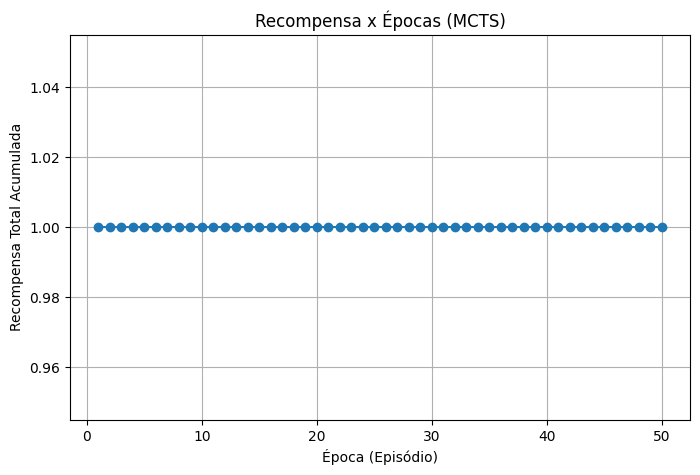

In [6]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(total_rewards) + 1), total_rewards, marker='o')
plt.xlabel("Época (Episódio)")
plt.ylabel("Recompensa Total Acumulada")
plt.title("Recompensa x Épocas (MCTS)")
plt.grid(True)
plt.show()

Ep 1, Ação: 2, Recompensa: 0.0, Estado: 0, Próx Estado: 1
Ep 1, Ação: 3, Recompensa: 0.0, Estado: 1, Próx Estado: 1
Ep 1, Ação: 2, Recompensa: 0.0, Estado: 1, Próx Estado: 2
Ep 1, Ação: 1, Recompensa: 0.0, Estado: 2, Próx Estado: 6
Ep 1, Ação: 1, Recompensa: 0.0, Estado: 6, Próx Estado: 10
Ep 1, Ação: 1, Recompensa: 0.0, Estado: 10, Próx Estado: 14
Ep 1, Ação: 2, Recompensa: 1.0, Estado: 14, Próx Estado: 15
Ep 2, Ação: 1, Recompensa: 0.0, Estado: 0, Próx Estado: 4
Ep 2, Ação: 1, Recompensa: 0.0, Estado: 4, Próx Estado: 8
Ep 2, Ação: 0, Recompensa: 0.0, Estado: 8, Próx Estado: 8
Ep 2, Ação: 2, Recompensa: 0.0, Estado: 8, Próx Estado: 9
Ep 2, Ação: 1, Recompensa: 0.0, Estado: 9, Próx Estado: 13
Ep 2, Ação: 2, Recompensa: 0.0, Estado: 13, Próx Estado: 14
Ep 2, Ação: 2, Recompensa: 1.0, Estado: 14, Próx Estado: 15
Ep 3, Ação: 3, Recompensa: 0.0, Estado: 0, Próx Estado: 0
Ep 3, Ação: 1, Recompensa: 0.0, Estado: 0, Próx Estado: 4
Ep 3, Ação: 0, Recompensa: 0.0, Estado: 4, Próx Estado: 4
Ep 3

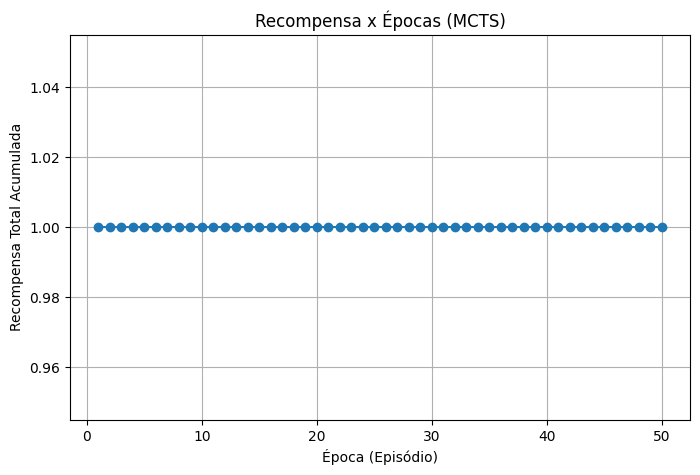

In [7]:
num_mcts_episodes = 50
num_simulations_per_decision = 100
rollout_depth = 150

# Cria novamente o ambiente (ou reabre) para executar
env = gym.make('FrozenLake-v1', is_slippery=False)

mcts_episodes = MPC_with_MCTS(env, model, 
                              num_episodes=num_mcts_episodes, 
                              num_simulations=num_simulations_per_decision, 
                              rollout_depth=rollout_depth)

env.close()

print(f"Total de episódios gerados pelo MCTS: {len(mcts_episodes)}")
print(f"Exemplo de transição no primeiro episódio gerado pelo MCTS: {mcts_episodes[0][0]}")
print(f"Tamanho do primeiro episódio gerado pelo MCTS: {len(mcts_episodes[0])}")
print(f"Exemplo de episódio gerado pelo MCTS: {mcts_episodes[0]}")

total_rewards = []
for ep in mcts_episodes:
    episode_reward = sum(transition[2] for transition in ep)
    total_rewards.append(episode_reward)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(total_rewards) + 1), total_rewards, marker='o')
plt.xlabel("Época (Episódio)")
plt.ylabel("Recompensa Total Acumulada")
plt.title("Recompensa x Épocas (MCTS)")
plt.grid(True)
plt.show()